# tf2 전이학습 및 파인튜닝

## 자체 데이터 전이학습

In [1]:
import os
import shutil

# import glob
import pathlib
import PIL
from PIL import Image

import cv2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
3
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tqdm.notebook import tqdm

import time
import datetime

## 소스 준비

### 이미지 경로

In [16]:
# img_save_root = './src/brand_by'
img_save_root = '/Users/noh/DeepLearning/Bags/front_b_images'

### 학습/검증/테스트 데이터 로드 및 분리

In [17]:
data_dir = pathlib.Path(img_save_root)
print('data_dir:::', data_dir)

image_count = len(list(data_dir.glob('*/*.png'))) + len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.jpeg')))
print('image_count:::', image_count)

data_dir::: /Users/noh/DeepLearning/Bags/front_b_images
image_count::: 7295


In [18]:
# lv_br = list(data_dir.glob('lv/*.jpg'))
# PIL.Image.open(str(lv_br[0]))

In [19]:
batch_size = 32*2
img_height = 229
img_width = 229
IMG_SIZE = (img_height, img_width)

# 학습 데이터 로드
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=batch_size)

# 검증 데이터 로드
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=batch_size)

# 검증 데이터 검증/테스트 데이터로 분리
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

# 클래스 종류 확인
class_names = train_dataset.class_names
print('class_names:::', class_names)

num_classes = len(class_names)
print('num_classes:::', num_classes)

# summary
print('-'*10)
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Found 7295 files belonging to 6 classes.
Using 5836 files for training.
Found 7295 files belonging to 6 classes.
Using 1459 files for validation.
class_names::: ['CHNL', 'GUCCI', 'HRMS', 'LV', 'PRADA', 'YSL']
num_classes::: 6
----------
Number of train batches: 92
Number of validation batches: 12
Number of test batches: 11


In [20]:
# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
#         plt.axis("off")

## 모델 적용

### 데이터 입력 최적화
train_dataset.prefetch: 데이터셋 입력 파이프라인이 요청에 따라서 하드디스크의 데이터를 메모리로 옮길 때의 버퍼링 방식 설정

AUTOTUNE: 텐서플로의 데이터 요청에 따라서 데이터셋이 미리 다음 데이터들을 메모리에 올려놓는 버퍼링 작업을 수행시 AUTOTUNE을 통해 고정적인 크기로 미리 올려놓는것이 아니라 하드웨어의 상황에 따라서 적절히 버퍼링 크기를 동적으로 바꾸는 것을 의미

In [21]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### 멀티 GPU 설정 

In [22]:
# 멀티 GPU 설정
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [23]:
# dir(tf.keras.layers.experimental.preprocessing)

### 모델 조립

In [24]:
# 멀티 GPU 설정 안에서 모델 컴파일
with mirrored_strategy.scope():
    ######################################################################
    # Pre-Processing
    # -------- 데이터 증강
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
        # tf.keras.layers.experimental.preprocessing.RandomCrop(height=int(img_height), width=int(img_width), seed=123),
        tf.keras.layers.experimental.preprocessing.RandomTranslation(
            height_factor=0.3, width_factor=0.3, fill_mode='constant',
            interpolation='bilinear', seed=123, fill_value=1.0),
        tf.keras.layers.GaussianNoise(stddev=0.1),
    ])
    # -------- 스케일 조정(0 ~ 255 --> 0.0 ~ 1.0 등등)
    # preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input
    
    ######################################################################
    # Feature Extractor
    # -------- pre-trained 모델 로드
    IMG_SHAPE = IMG_SIZE + (3,)
#     base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                    include_top=False,
#                                                    weights='imagenet')
    
    base_model = tf.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
    
    print("Number of layers in the base model: ", len(base_model.layers))
    
    # feature extractor 부분 학습 안하도록 설정  
    base_model.trainable = False
    
    #### 1st 학습때부터 파인튜닝
    ## 동결된 모델(feature extractor 부분)과 커스텀 레이어의 영역을 적절히 선택하여 학습시키기 ##
    base_model.trainable = True
    print("Number of layers in the base model: ", len(base_model.layers))
    # Fine-tune from this layer onwards
    fine_tune_at = 520
    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable =  False
    ####
    
    ######################################################################
    # FNC / classifier
    # -------- GAP
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    # -------- Softmax Layer
    prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
    
    
    ######################################################################
    # 커스텀 모델 조립
    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)

    base_learning_rate = 0.0003 #  0.0001 원래값
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

219062272/219055592 [==============================] - 15s 0us/step
Number of layers in the base model:  780
Number of layers in the base model:  780


/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [25]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 229, 229, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 229, 229, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 229, 229, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 229, 229, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0     

### 학습

In [26]:
# # 임시 검증
# loss0, accuracy0 = model.evaluate(validation_dataset)

In [27]:
# epochs
initial_epochs = 40

In [28]:
## 시간 측정 시작 ##
start_now = time.localtime()
initialTime = time.time()

#
time_stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# ----------- tensorboard
# 결과 로그 경로
log_dir = f'./logs_{time_stamp}/fit/{time_stamp}'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
# tensorboard 콜백 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# ----------- checkpoint
# checkpoint 경로
prefix_path = f'./logs_{time_stamp}/ckpt/training-{time_stamp}'
checkpoint_path = os.path.join(prefix_path, "cp-{epoch:04d}.ckpt")
checkpoint_dir = os.path.dirname(checkpoint_path)
# 체크포인트 콜백
cp_per = initial_epochs / 2
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=cp_per)

# 초기 가중치 저장
model.save_weights(checkpoint_path.format(epoch=0))

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[tensorboard_callback, cp_callback])

Epoch 1/40


/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


InvalidArgumentError:  Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]
	 [[MultiDeviceIteratorGetNextFromShard]]
	 [[RemoteCall]]
	 [[IteratorGetNextAsOptional]] [Op:__inference_train_function_50089]

Function call stack:
train_function


In [15]:
## 시간 측정 끝 ##

# 시작 시간 스탬프
print("Training 1st Start at %04d/%02d/%02d %02d:%02d:%02d" % \
      (start_now.tm_year, start_now.tm_mon, start_now.tm_mday, start_now.tm_hour, start_now.tm_min, start_now.tm_sec))

end_now = time.localtime()
print("Training 1st End at %04d/%02d/%02d %02d:%02d:%02d" % \
      (end_now.tm_year, end_now.tm_mon, end_now.tm_mday, end_now.tm_hour, end_now.tm_min, end_now.tm_sec))

elapsed_time_1st = round(time.time() - initialTime, 4)
cal_time_easy = str(datetime.timedelta(seconds=elapsed_time_1st))
try:
    cal_time_easy = cal_time_easy.split('.')[0]
except:
    pass

print('Training 1st takes', cal_time_easy)

Training 1st Start at 2021/05/20 17:13:29
Training 1st End at 2021/05/21 01:27:57
Training 1st takes 8:14:27


## 결과 시각화

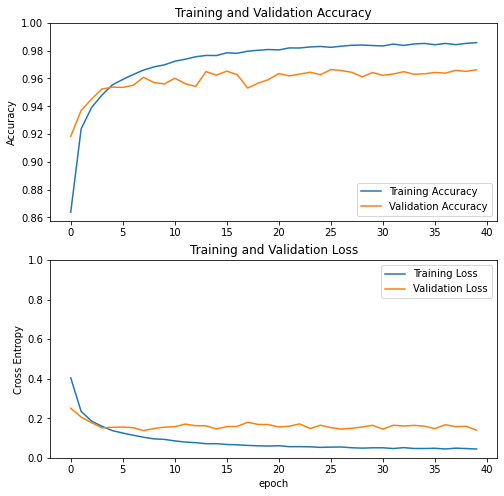

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [17]:
initial_epochs# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')

# plt.legend(loc='right')
# plt.ylabel('Accuracy & Loss')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy & Loss')

# plt.xlabel('epoch')
# plt.show()

40

## 파인튜닝

### 파인튜닝으로 학습시킬 레이어 설정

In [18]:
## 동결된 모델(feature extractor 부분)과 커스텀 레이어의 영역을 적절히 선택하여 학습시키기 ##

base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 520

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  780


In [19]:
# 멀티 GPU 설정 안에서 모델 컴파일
with mirrored_strategy.scope():
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/10),
                  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 229, 229, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 229, 229, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 229, 229, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 229, 229, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0     

In [21]:
# # 레이어 설정 동결 확인
# for layer in model.layers:
#     print('-'*2)
#     print(layer.name)
#     if layer.name == 'mobilenetv2_1.00_160':
#         for base_layer in layer.layers:
#             print(base_layer.trainable)

### 파인튜닝을 위한 재학습
이전 학습에 이어서 학습을 시킴

In [22]:
## 시간 측정 시작 ##
start_now = time.localtime()
initialTime = time.time()

fine_tune_epochs = 80
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[tensorboard_callback, cp_callback])

Epoch 40/120
INFO:tensorflow:batch_all_reduce: 164 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 164 all-reduces with algorithm = nccl, num_packs = 1
1575/1575 [==============================] - 786s 476ms/step - loss: 0.0334 - accuracy: 0.9887 - val_loss: 0.1469 - val_accuracy: 0.9706
Epoch 41/120
1575/1575 [==============================] - 739s 468ms/step - loss: 0.0257 - accuracy: 0.9916 - val_loss: 0.1316 - val_accuracy: 0.9723
Epoch 42/120
1575/1575 [==============================] - 739s 467ms/step - loss: 0.0203 - accuracy: 0.9931 - val_loss: 0.1463 - val_accuracy: 0.9720
Epoch 43/120
1575/1575 [==============================] - 739s 467ms/step - loss: 0.0207 - accuracy: 0.9933 - val_loss: 0.1374 - val_accuracy: 0.9723
Epoch 44/120
1575/1575 [==============================] - 739s 468ms/step - loss: 0.0204 - accuracy: 0.9930 - val_loss: 0.1413 - val_accuracy: 0.9728
Epoch 45/120
1575/1575 [==============================] - 740s 468ms/step - 

In [23]:
## 시간 측정 끝 ##

# 시작 시간 스탬프
print("Training 2nd Start at %04d/%02d/%02d %02d:%02d:%02d" % \
      (start_now.tm_year, start_now.tm_mon, start_now.tm_mday, start_now.tm_hour, start_now.tm_min, start_now.tm_sec))

end_now = time.localtime()
print("Training 2nd End at %04d/%02d/%02d %02d:%02d:%02d" % \
      (end_now.tm_year, end_now.tm_mon, end_now.tm_mday, end_now.tm_hour, end_now.tm_min, end_now.tm_sec))

elapsed_time_2nd = round(time.time() - initialTime, 4)
cal_time_easy = str(datetime.timedelta(seconds=elapsed_time_2nd))
try:
    cal_time_easy = cal_time_easy.split('.')[0]
except:
    pass

print('Training 2nd takes', cal_time_easy)

Training 2nd Start at 2021/05/21 01:27:58
Training 2nd End at 2021/05/21 18:06:49
Training 2nd takes 16:38:51


In [24]:
cal_time_easy = str(datetime.timedelta(seconds=elapsed_time_1st+elapsed_time_2nd))
try:
    cal_time_easy = cal_time_easy.split('.')[0]
except:
    pass

print('Training Total takes', cal_time_easy)

Training Total takes 1 day, 0:53:19


### 파인튜닝 학습 시각화

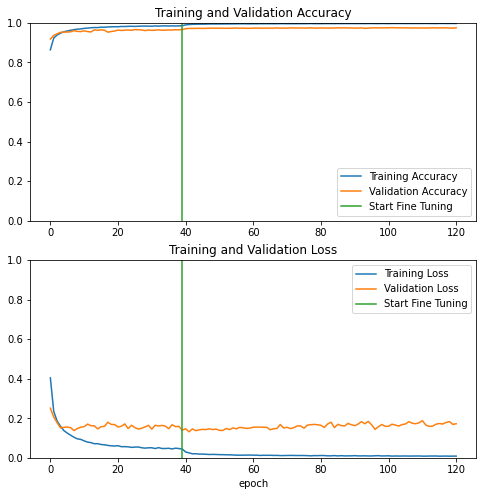

In [25]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 검증
test 데이터셋으로 평가하기

In [26]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

197/197 [==============================] - 78s 380ms/step - loss: 0.1886 - accuracy: 0.9762
Test accuracy : 0.976205587387085


## 예측

In [27]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

predictions = model.predict_on_batch(image_batch)
# 확률 제일 큰 값과 인덱스 찾기
predictions_max_val = np.max(predictions, axis=1)  # 최대값(==확률)
predictions_max_val_idx = np.argmax(predictions, axis=1)  # 인덱스(==클래스 순번)

In [28]:
# 맞춘 항목 확인
result_chk = label_batch - predictions_max_val_idx
result_chk = tf.where(result_chk == 0, 1, 0)

print('Predictions:\n', predictions_max_val_idx)
print('Labels:\n', label_batch)
print('result_chk:\n', result_chk.numpy())

Predictions:
 [1 3 0 3 0 4 3 3 4 4 3 3 2 3 5 3 3 4 4 5 1 3 3 2 3 5 1 0 3 0 3 0 3 2 3 3 0
 5 1 0 3 0 3 5 3 3 0 3 3 0 1 3 1 3 5 1 3 5 1 2 3 3 3 3]
Labels:
 [1 3 0 3 0 4 3 3 4 4 3 3 2 3 0 3 3 4 4 5 1 3 3 2 3 5 1 0 3 0 3 0 3 2 3 3 0
 5 1 0 3 0 3 5 3 3 0 3 3 0 1 3 1 3 5 1 3 5 1 2 3 3 3 3]
result_chk:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


complete!!!


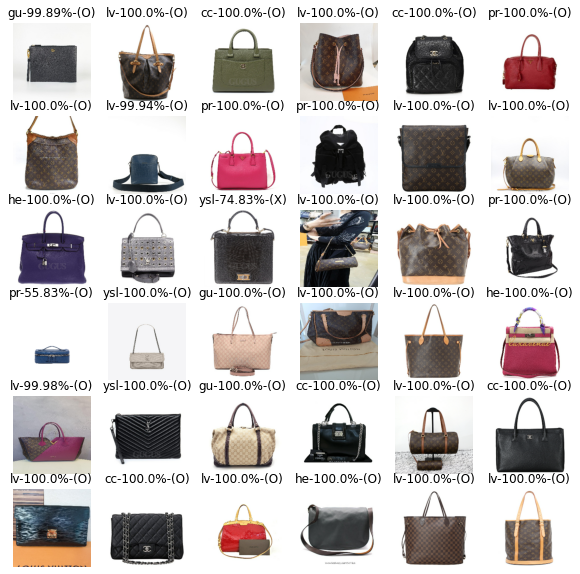

In [29]:
row_size = 6
col_size = 6
num_item = row_size * col_size

plt.figure(figsize=(10, 10))
for i in range(num_item):
    ax = plt.subplot(row_size, col_size, i + 1)
    
    try:
        fig_img = image_batch[i]
    except IndexError:
        pass
    else:
        plt.imshow(fig_img.astype("uint8"))

        pred_cls_name = class_names[predictions_max_val_idx[i]]
        pred_cls_pernt = round(predictions_max_val[i] * 100, 2)
        real_cls_name = class_names[label_batch[i]]

        if result_chk[i] == 1:
            is_crrt_answ = 'O'
        elif result_chk[i] == 0:
            is_crrt_answ = 'X'

        plt.title(pred_cls_name + '-' + f'{pred_cls_pernt}%' + '-' + f'({is_crrt_answ})')
    plt.axis("off")

    
print('complete!!!')

In [30]:
# #### 전체 테스트 결과 보기
# for i in test_dataset.as_numpy_iterator():
#     image_batch, label_batch = i
    
#     predictions = model.predict_on_batch(image_batch)
#     # 확률 제일 큰 값과 인덱스 찾기
#     predictions_max_val = np.max(predictions, axis=1)  # 최대값(==확률)
#     predictions_max_val_idx = np.argmax(predictions, axis=1)  # 인덱스(==클래스 순번)
    
#     # 맞춘 항목 확인
#     result_chk = label_batch - predictions_max_val_idx
#     result_chk = tf.where(result_chk == 0, 1, 0)
    
#     print('-'*10)
#     print('result graph')
    
#     row_size = 5
#     col_size = 5
#     num_item = row_size * col_size

#     plt.figure(figsize=(10, 10))
#     for i in range(num_item):
#         ax = plt.subplot(row_size, col_size, i + 1)

#         try:
#             fig_img = image_batch[i]
#         except IndexError:
#             pass
#         else:
#             plt.imshow(fig_img.astype("uint8"))

#             pred_cls_name = class_names[predictions_max_val_idx[i]]
#             pred_cls_pernt = round(predictions_max_val[i] * 100, 2)
#             real_cls_name = class_names[label_batch[i]]

#             if result_chk[i] == 1:
#                 is_crrt_answ = 'O'
#             elif result_chk[i] == 0:
#                 is_crrt_answ = 'X'

#             plt.title(pred_cls_name + '-' + f'{pred_cls_pernt}%' + '-' + f'({is_crrt_answ})')
#             plt.axis("off")
    
#     time.sleep(10)
    
    
# print('complete!!!')

## 모델 저장

In [31]:
md_save_dir = f'./logs_{time_stamp}/saved_model'
if not os.path.exists(md_save_dir):
    os.makedirs(md_save_dir)
    
md_save_path = os.path.join(md_save_dir, f'{time_stamp}.h5')

model.save(md_save_path)

## 싱글 이미지 테스트

In [32]:
from keras.preprocessing import image

Using TensorFlow backend.


Predictions:
 [3]
img name::: /home/ubuntu/Downloads/lv_ex.jpg
complete!!!


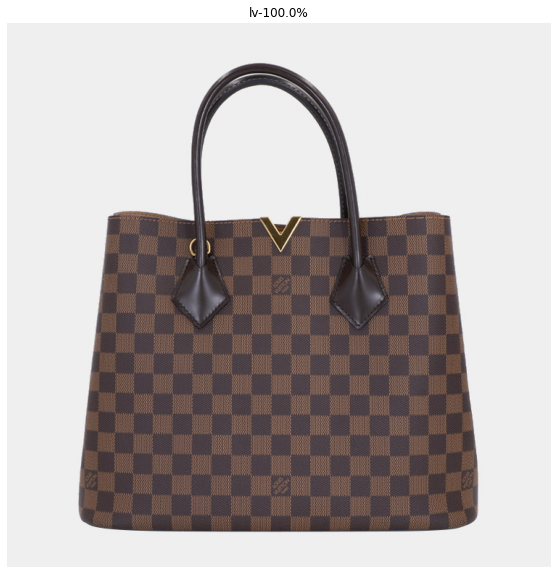

In [33]:
# 소스 로드
excloset_im_pa = '/home/ubuntu/Downloads/lv_ex.jpg'
# excloset_im_pa = '/home/ubuntu/Downloads/cc_ex.jpg'
# excloset_im_pa = '/home/ubuntu/Downloads/he_ex.jpg'
# excloset_im_pa = '/home/ubuntu/Downloads/gu_ex.jpg'
# excloset_im_pa = '/home/ubuntu/Downloads/pr_ex.jpg'
# excloset_im_pa = '/home/ubuntu/Downloads/ysl_ex.jpg'

img = image.load_img(excloset_im_pa, target_size=IMG_SIZE)
img = image.img_to_array(img)

img = np.expand_dims(img, axis = 0)

# 예측
predictions = model.predict(img)
predictions_max_val = np.max(predictions, axis=1)  # 최대값(==확률)
predictions_max_val_idx = np.argmax(predictions, axis=1)  # 인덱스(==클래스 순번)

print('Predictions:\n', predictions_max_val_idx)
print('img name:::', excloset_im_pa)

plt.figure(figsize=(10, 10))
for i in range(1):
    ax = plt.subplot(1, 1, i + 1)
    
    fig_img = PIL.Image.open(excloset_im_pa)
    plt.imshow(fig_img)

    pred_cls_name = class_names[predictions_max_val_idx[i]]
    pred_cls_pernt = round(predictions_max_val[i] * 100, 2)
    plt.title(pred_cls_name + '-' + f'{pred_cls_pernt}%')
    plt.axis("off")

    
print('complete!!!')